In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='sample_data',train=True,download=True,transform=Compose([ToTensor(), Normalize(mean=(0.5,),std=(0.5,))]))

In [2]:
import matplotlib.pyplot as plt
img, label = mnist[0]
print(f'Label: {label}')
print(img)

Label: 5
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1

In [3]:
### Denormalizing the NOrmalized Input
def denorm(x):
  return (x+1)/2

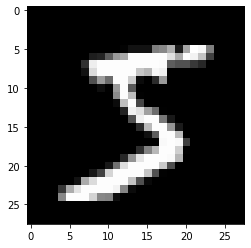

In [4]:
plt.imshow(denorm(img[0]), cmap='gray')

### Finally Lets Create a dataloader to load the images in batches

In [5]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle=True)

First batch
torch.Size([100, 1, 28, 28])
torch.Size([100])
tensor(3)


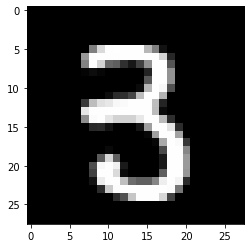

In [6]:
for img_batch, label_batch in data_loader:
  print('First batch')
  print(img_batch.shape)
  print(label_batch.shape)
  print(label_batch[0])
  plt.imshow(denorm(img_batch[0][0]),cmap='gray')
  break

In [7]:
### Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

###Discriminator Network

In [9]:
img_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn
D = nn.Sequential(
    nn.Linear(img_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

In [11]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### Generator Network

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,img_size),
    nn.Tanh() ### To make it look like a Normalized Image as we did in preprocessing
)

In [14]:
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

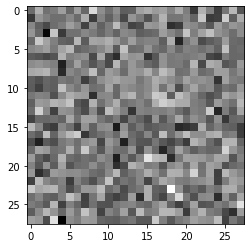

In [15]:
plt.imshow(gen_imgs[0],cmap='gray')

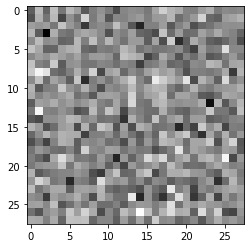

In [16]:
plt.imshow(gen_imgs[1],cmap='gray')

In [17]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

### Discriminator Training

* As Discriminator is a classifier we can use a Binary Class Entropy Loss

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

##### Lets define Helper functions to reset gradients and train the discriminator

In [19]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [20]:
def train_discriminator(images):
  
  # Create the labels which are later used ad input for the BCE loss
  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)

  # Loss for real images
  outputs = D(images)
  d_loss_real = criterion(outputs,real_labels)
  real_score = outputs

  # Loss for fake images
  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs,fake_labels)
  fake_score = outputs

  # Combine losses
  d_loss = d_loss_real + d_loss_fake

  # Reset Gradients
  reset_grad()

  #Compute Gradients
  d_loss.backward()

  # Adjust the parameters using the backprop
  d_optimizer.step()

  return d_loss, real_score, fake_score

### Generator Traning

* Discriminator will be the loss function while training the Generator

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():
  
  # Generate fake images and calculate loss
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size,1).to(device)
  g_loss = criterion(D(fake_images), labels)

  # Backprop and Optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()

  return g_loss, fake_images

### Training Model

In [23]:
import os
sample_dir = 'sample_data/output'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

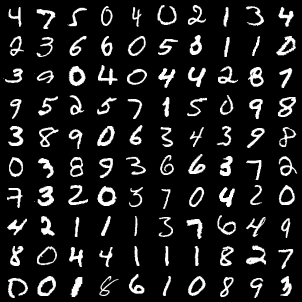

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save Some Real Images
for images,_ in data_loader:
  images = images.reshape(images.size(0),1,28,28)
  save_image(denorm(images),os.path.join(sample_dir, 'real_images.png'), nrow=10)
  break

Image(os.path.join(sample_dir,'real_images.png'))

Saving fake_images-0000.png


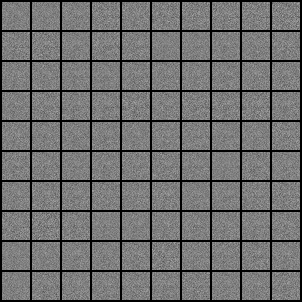

In [25]:
sample_vectors = torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_fname)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=10)

### Before Training
save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

In [26]:
% time
num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
  for i, (images,_) in enumerate(data_loader):
    # Load a batch & transform to vetors
    images = images.reshape(batch_size,-1).to(device)

    # Train the discriminator and generator
    d_loss, real_score, fake_score = train_discriminator(images)
    g_loss, fake_images = train_generator()

    # Inspect the losses
    if (i+1) % 200 == 0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
  # Sample and save images
  save_fake_images(epoch+1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Epoch [0/300], Step [200/600], d_loss: 0.0452, g_loss: 3.9600, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0863, g_loss: 5.5157, D(x): 0.97, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0672, g_loss: 4.9138, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0375, g_loss: 5.0033, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.1696, g_loss: 4.0386, D(x): 0.93, D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0893, g_loss: 4.5471, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.6141, g_loss: 2.2881, D(x): 0.78, D(G(z)): 0.21
Epoch [2/300], Step [400/600], d_loss: 0.4139, g_loss: 4.4837, D(x): 0.87, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.3085, g_loss: 2.9368, D(x): 0.89, D(G(z)): 0.14
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5535, g_lo

In [27]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

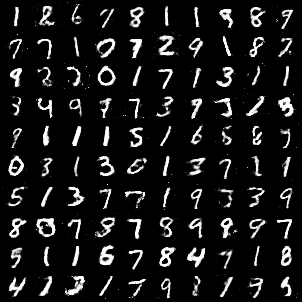

In [28]:
Image('./sample_data/output/fake_images-0300.png')

In [29]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

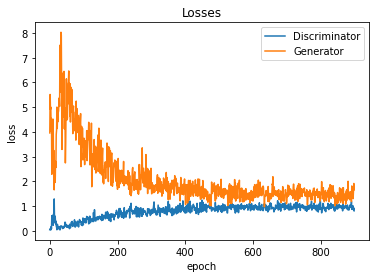

In [30]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

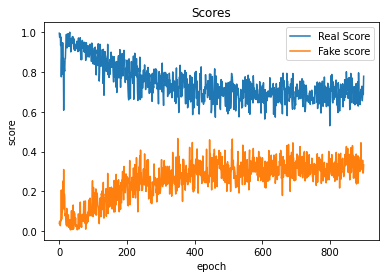

In [31]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');